# Group 1 Capstone Project Work
### Make sure to make / checkout your own branch before making changes

# Maddie Hince

In [10]:
import pandas as pd
import sqlite3

df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
df.head()


conn = sqlite3.connect('zippedData/im.db.zip')
pd.read_sql("""SELECT *""")

DatabaseError: Execution failed on sql '
SELECT *
FROM im
': file is not a database

# Cat Murad

In [150]:
import pandas as pd
import sqlite3

df_gross = pd.read_csv('zippedData/tmdb.movies.csv.gz')
df_gross.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [165]:
df_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', delimiter='\t')
df_info.head()
df_info.dropna(inplace=True)
df_info
#rt.movie_info.tsv.gz

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
6,10,Some cast and crew from NBC's highly acclaimed...,PG-13,Comedy,Jake Kasdan,Mike White,"Jan 11, 2002","Jun 18, 2002",$,"41,032,915",82 minutes,Paramount Pictures
7,13,"Stewart Kane, an Irishman living in the Austra...",R,Drama,Ray Lawrence,Raymond Carver|Beatrix Christian,"Apr 27, 2006","Oct 2, 2007",$,"224,114",123 minutes,Sony Pictures Classics
15,22,Two-time Academy Award Winner Kevin Spacey giv...,R,Comedy|Drama|Mystery and Suspense,George Hickenlooper,Norman Snider,"Dec 17, 2010","Apr 5, 2011",$,"1,039,869",108 minutes,ATO Pictures
18,25,"From ancient Japan's most enduring tale, the e...",PG-13,Action and Adventure|Drama|Science Fiction and...,Carl Erik Rinsch,Chris Morgan|Hossein Amini,"Dec 25, 2013","Apr 1, 2014",$,"20,518,224",127 minutes,Universal Pictures
...,...,...,...,...,...,...,...,...,...,...,...,...
1530,1968,"This holiday season, acclaimed filmmaker Camer...",PG,Comedy|Drama,Cameron Crowe,Aline Brosh McKenna|Cameron Crowe,"Dec 23, 2011","Apr 3, 2012",$,"72,700,000",126 minutes,20th Century Fox
1537,1976,"Embrace of the Serpent features the encounter,...",NR,Action and Adventure|Art House and International,Ciro Guerra,Ciro Guerra|Jacques Toulemonde Vidal,"Feb 17, 2016","Jun 21, 2016",$,"1,320,005",123 minutes,Buffalo Films
1541,1980,A band of renegades on the run in outer space ...,PG-13,Action and Adventure|Science Fiction and Fantasy,Joss Whedon,Joss Whedon,"Sep 30, 2005","Dec 20, 2005",$,"25,335,935",119 minutes,Universal Pictures
1542,1981,"Money, Fame and the Knowledge of English. In I...",NR,Comedy|Drama,Gauri Shinde,Gauri Shinde,"Oct 5, 2012","Nov 20, 2012",$,"1,416,189",129 minutes,Eros Entertainment


In [174]:
#make box office into int - trying to see what genre did best
df_info['box_office'] = df_info['box_office'].str.replace(",","")
df_info['box_office'] = df_info['box_office'].astype(int)

In [177]:
df_info.sort_values(by='box_office', ascending=False)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
827,1071,This depiction of the last 12 hours in the lif...,R,Drama,Mel Gibson,Mel Gibson|Benedict Fitzgerald,"Feb 25, 2004","Aug 31, 2004",$,368000000,127 minutes,Newmarket Film Group
877,1136,The Hobbit: An Unexpected Journey follows titl...,PG-13,Action and Adventure|Science Fiction and Fantasy,Peter Jackson,Peter Jackson|Philippa Boyens|Guillermo del To...,"Dec 14, 2012","Mar 19, 2013",$,303001229,170 minutes,Warner Bros.
1188,1525,"In Skyfall, Bond's loyalty to M is tested as h...",PG-13,Action and Adventure|Mystery and Suspense,Sam Mendes,John Logan|Robert Wade|Neal Purvis,"Nov 9, 2012","Mar 11, 2013",$,299300000,145 minutes,MGM
690,883,"Now that Greg Focker is ""in"" with his soon-to-...",PG-13,Comedy,Jay Roach,Jim Herzfeld|John Hamburg,"Dec 22, 2004","Apr 26, 2005",$,279167575,118 minutes,Universal Pictures
1117,1442,Youthful wizard Harry Potter returns to the sc...,PG,Kids and Family|Science Fiction and Fantasy,Chris Columbus,Steve Kloves,"Nov 15, 2002","Apr 11, 2003",$,261835892,161 minutes,Warner Bros. Pictures
...,...,...,...,...,...,...,...,...,...,...,...,...
1353,1747,College freshman Adam Buckley sits blindfolded...,R,Drama|Mystery and Suspense,Will Canon,Will Canon|Douglas Simon,"Feb 18, 2011","May 17, 2011",$,16632,81 minutes,Phase 4 Films
1269,1639,In this darkly erotic drama from cult filmmake...,NR,Art House and International|Drama,Jeanne Labrune,Jeanne Labrune|Richard Debuisne,"Aug 26, 2011","Jan 17, 2012",$,8856,95 minutes,First Run Features
691,884,Freebie (James Caan) and the Bean (Alan Arkin)...,R,Action and Adventure|Comedy|Drama,Richard Rush,Robert Kaufman,"Dec 25, 1974","Jan 11, 2011",$,8300,114 minutes,Warner Bros. Pictures
697,895,"After a sexual assault by a random stranger, S...",NR,Drama|Horror|Mystery and Suspense,Eric England,Eric England,"Nov 22, 2013","Mar 18, 2014",$,3328,84 minutes,IFC Films


In [5]:
conn = sqlite3.connect('im.db')

In [30]:
pd.read_sql('select * from movie_akas', conn)

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0
...,...,...,...,...,...,...,...,...
331698,tt9827784,2,Sayonara kuchibiru,None,None,original,None,1.0
331699,tt9827784,3,Farewell Song,XWW,en,imdbDisplay,None,0.0
331700,tt9880178,1,La atención,None,None,original,None,1.0
331701,tt9880178,2,La atención,ES,None,None,None,0.0


In [13]:
pd.read_sql('select * from movie_basics', conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [121]:
q = pd.read_sql('''select distinct b.primary_title, b.genres, r.averagerating 
        from movie_basics b
        join movie_ratings r
            on b.movie_id = r.movie_id
        join movie_akas a
            on r.movie_id = a.movie_id
        where start_year >= 2010 and a.language is not Null and b.genres is not Null
        group by genres
        order by averagerating DESC''', conn)
q

,primary_title,genres,averagerating
0,42nd Street: The Musical,Musical,9.1
1,My Champion,"Documentary,Sport",9.1
2,Twice Upon a Time,"Documentary,Family,War",9.0
3,The King,"Documentary,Family,Sport",8.9
4,Rock in the Red Zone,"Documentary,Music,War",8.8
...,...,...,...
622,Little Tigers,"Action,Comedy,War",2.8
623,The Brides of Sodom,"Fantasy,Horror,Sci-Fi",2.6
624,Vecherinka '1 noyabrya': Po Stranitsam detskih...,"Comedy,Fantasy,Sci-Fi",2.2
625,Khaltoor,"Action,Comedy,Musical",2.1


#### From above we can see that 
 - 13/20 films with the highest average ratings have the Documentary genre listed.
 - Other popular genres: war, sport, family, adventure, crime, thriller, drama

In [122]:
df = pd.DataFrame(q, columns = ['primary_title', 'genres', 'averagerating'])
print(df.head())

              primary_title                    genres  averagerating
0  42nd Street: The Musical                   Musical            9.1
1               My Champion         Documentary,Sport            9.1
2         Twice Upon a Time    Documentary,Family,War            9.0
3                  The King  Documentary,Family,Sport            8.9
4      Rock in the Red Zone     Documentary,Music,War            8.8


In [99]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0, 0.5, 'Rating')

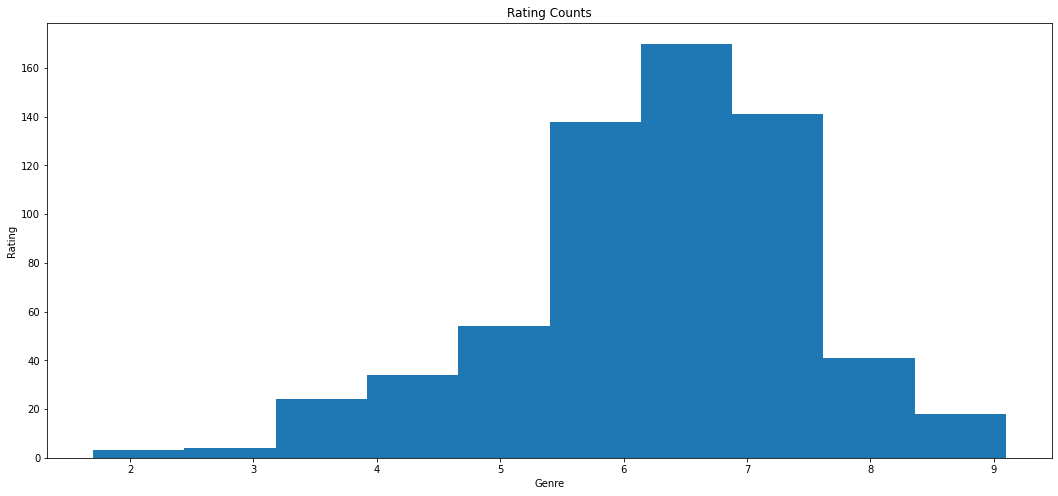

In [123]:
# Plot the ratings and their counts

fig, ax = plt.subplots(figsize=(18, 8)) # Two figures side by side
#ax_lft = axes[0]
#df['averagerating'].hist()
ax.hist(df['averagerating'])
ax.set_title('Rating Counts')
ax.set_xlabel('Genre')
ax.set_ylabel('Rating')

In [128]:
pd.read_sql('''select avg(averagerating) from movie_ratings''', conn)

,avg(averagerating)
0,6.332729


In [157]:
q2 = pd.read_sql('''select distinct b.primary_title, d.person_id, p.primary_name, r.averagerating
        from movie_basics b
        join movie_ratings r
            on b.movie_id = r.movie_id
        join writers d
            on b.movie_id = d.movie_id
        join persons p
            on d.person_id = p.person_id
        where start_year >= 2010
        group by primary_name
        order by averagerating DESC''', conn)
q2

,primary_title,person_id,primary_name,averagerating
0,Hercule contre Hermès,nm0880350,Mohamed Ulad-Mohand,10.0
1,Revolution Food,nm7223265,Loreto Di Cesare,10.0
2,Fly High: Story of the Disc Dog,nm7633303,Lindsay Thompson,10.0
3,Exteriores: Mulheres Brasileiras na Diplomacia,nm10616933,Ivana Diniz,10.0
4,Pick It Up! - Ska in the '90s,nm9500109,Heather Augustyn,10.0
...,...,...,...,...
75468,Badang,nm2704950,Azhari Mohd Zain,1.0
75469,Mr. Home,nm5590847,Ayumu Hasegawa,1.0
75470,Ramo Trip,nm4923017,Ayako Yamaguchi,1.0
75471,6 elementov vremeni,nm8400131,Alexey Voorhis,1.0


In [130]:
df2 = pd.DataFrame(q2, columns = ['primary_title', 'genres', 'averagerating'])
print(df2.head())

                     primary_title                    genres  averagerating
0               The Irish Prisoner   History,Romance,Western            7.5
1              Mysteries of Lisbon     Drama,Mystery,Romance            7.5
2                       The Reason     Drama,Fantasy,History            7.5
3                   Les Invisibles       Documentary,Romance            7.5
4  China: The Rebirth of an Empire  Documentary,History,News            7.5


# Elijah Soba

# Luis Estrada 

# Kilmar Lazo 

# Michael Eugene